# Individual Milestone

## by Andrii Voitkiv

In [4]:
# Helper function for making tables look pretty
from prettytable import PrettyTable


def generate_ascii_table(df):
    '''
    Reference: https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
    '''
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    return x

## Introduction

 In this Individual Milestone, I will focus familiarizing myself with stores aspect of Vancouver city using SQL for data exploration. I will be using one table generated by City of Vancouver Open Data Portal. This table have been pre-cleaned in python (renaming columns, dropping insignificant ones).
 
 To begin, start by:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sqlalchemy as sq
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = 'plotly_dark'
% matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]  # default size
plt.rcParams['figure.dpi'] = 150  #  increase the default pixel density used for matplotlib plots

## Geopandas

In [120]:
#read the GeoJson file for the districts of Vancouver
# The file contains the Distirct name and the geometry
district_file_path = '/Users/berg/Projects/DATA/604/project/data/local-area-boundary.geojson'


def geoviz(path, df, category):
    district = gpd.read_file(district_file_path)
    # Let's index by district name
    cendf = district
    cendf.set_index('name', inplace=True)
    cendf_2 = cendf
    #left join the to the cendf file
    cendf_2['name_2'] = cendf_2.index
    cendf_3 = pd.merge(cendf_2, df, left_on='name_2', right_on='Area', how='left')
    cendf_4 = cendf_3.to_crs(epsg=4326)

    # plot the map
    fig = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
                               locations=cendf_4.index,
                               color="disparity",
                               color_continuous_scale='YlGnBu',
                               center={"lat": 49.246292, "lon": -123.116226},  # Vancouver
                               mapbox_style="carto-positron",
                               opacity=0.75,
                               zoom=11,
                               title='{0}'.format(category))

    fig.update_layout(margin={"r": 50, "t": 50, "l": 50, "b": 50},
                      autosize=True,
                      height=600)

    fig.show()

## Connect to DB

In [2]:
# connect to my database
user = 'andrii_voitkiv1'
password = '3RMB68NSY'
host = 'datasciencedb.ucalgary.ca'
database = 'andrii_voitkiv1'

# connect to shared database
# user = 'L01-01'
# password = '5@qN6CJg'
# host = 'datasciencedb.ucalgary.ca'
# database = 'L01-01'

engine = sq.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.format(user, password, host, database))

df_stores = pd.read_sql_table("stores", engine)

In [5]:
df_stores.nunique()

ID                 8194
Retail category       7
Year                  2
Area                 21
dtype: int64

In [6]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16230 entries, 0 to 16229
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               16230 non-null  int64 
 1   Retail category  16230 non-null  object
 2   Year             16230 non-null  int64 
 3   Area             16230 non-null  object
dtypes: int64(2), object(2)
memory usage: 507.3+ KB


## Part 1: Store Disparities in Vancouver city

**How the stores of different categories are distributed across areas of Vancouver?**

Answering this question will help us to understand _if people living in different areas have equal access to the stores of different kinds_. Ofcourse, we cannot expect that all areas are equal, meaning there are wealthy or poor neighbourhoods, touristic or industrial areas etc.

**Useful properties:**
1. 21 `Areas` in Vancouver;
2. 7 `Retail Categories` including Vacant (which means a space is not occupied);
3. 2 `Years` (2020, 2021).

**Methodology:**
1. Let's assume that in ideal state the number of stores is distributed equally. In our case it means that there are approx 4.76% of all stores per area (100% / 21 areas);
    - This is a very loose assumption. It's better to incorporate population (stores per person) or area (stores per square km). Therefore, I'm _not going to use_ this metric for now to measure disparity.
2. Regarding categories, I don't know what is the right proportion of categories in ideal state to satisfy needs of citizens of Vancouver. But let's assume that the city of Vancouver is well-balanced, meaning there is right amount of stores of different categories.
    - Then I can use this ideal (city) proportion to compare with each area's proportion;
    - The result of this analysis should hint us on disparities across areas.


### Step 1: Find proportion of categories on CITY level

In [7]:
query0 = '''
SELECT `Retail category`,
       COUNT(*)                         AS stores,
       COUNT(*) / SUM(COUNT(*)) OVER () AS ideal_prop
FROM stores
WHERE Year = 2021
GROUP BY 1
ORDER BY ideal_prop DESC;
'''

query_table0 = pd.read_sql_query(query0, engine)
generate_ascii_table(query_table0)

Retail category,stores,ideal_prop
Service Commercial,2434,0.3013
Food & Beverage,1972,0.2441
Comparison Goods,1386,0.1716
Convenience Goods,1020,0.1263
Vacant,989,0.1224
Entertainment and Leisure,163,0.0202
Automotive Goods & Services,114,0.0141


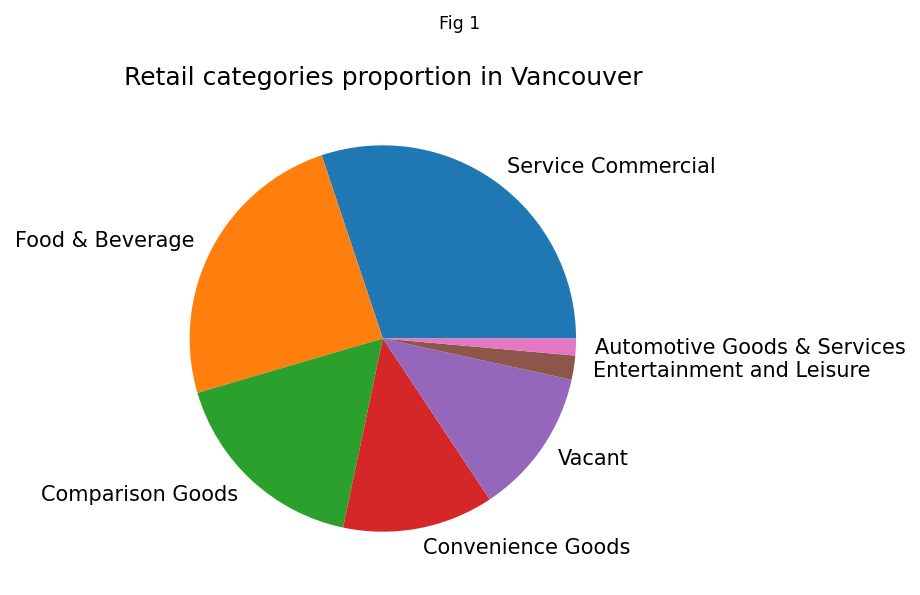

In [41]:
# Preparing data
query_table0 = query_table0.sort_values(by='ideal_prop', ascending=False)
# # Plotly
# fig1 = px.bar(query_table0, x='ideal_prop', y='Retail category' , color='ideal_prop', color_continuous_scale='Oranges' )
# fig1.update_layout(barmode='stack', yaxis={'categoryorder': 'total ascending'})
# fig1.update_layout(autosize=True, title='Retail category proportions in Vancouver ')
# fig1.show()
# Matplotlib
# Pie diagram
plt.pie(query_table0['ideal_prop'], labels=query_table0['Retail category'])
# Decoration
plt.title('Retail categories proportion in Vancouver')
plt.suptitle('Fig 1', fontsize='small')
plt.tight_layout()
# plt.show()

**Insights:**

1. The result above confirms my assumption that the city needs _an uneven proportion_ of different stores. People need Service Commercial, Food or Goods much more often than Entertainment or Automotive.
2. This will be our _ideal proportion_ of store categories. Eventually, I want to compare the Areas' proportions to the city's.

### Step 2: Find disparity in proportion of categories on AREA level

**Methodology:**

In this step, I'd like to compare the proportion of different categories of retails stores within each `Area` vs the proportion of categories within City level (as ideal proportion calculated in the previous step).

To _calculate the proportion of different categories of retails stores within each `Area`_ (name this variable `area_categ_prop`):
1. Count _all stores_ in area (`area_count`);
2. Count stores in every retail category in each area (`area_category_count`);
3. Then `area_categ_prop` = (2) / (1).

Finally, to find the disparity I will find the difference (`disparity`) between the result above and ideal proportion:
`area_categ_prop` - `ideal_prop`.


In [43]:
# Create VIEW
# to save space in future queries
query1 = '''
CREATE VIEW stores_disparity AS
(
SELECT a.Area,
       a.`Retail category`,
       a.area_category_count,
       b.area_count,
       d.ideal_categ_prop,
       a.area_category_count / b.area_count                      AS area_categ_prop,
       a.area_category_count / b.area_count - d.ideal_categ_prop AS disparity
FROM (SELECT Area, `Retail category`, COUNT(*) AS area_category_count
      FROM stores
      WHERE Year = 2021
      GROUP BY 1, 2) AS a
         LEFT OUTER JOIN
     (SELECT Area, COUNT(*) AS area_count
      FROM stores
      WHERE Year = 2021
      GROUP BY 1) AS b ON b.Area = a.Area
         LEFT OUTER JOIN
     (SELECT `Retail category`, COUNT(*) / SUM(COUNT(*)) OVER () AS ideal_categ_prop
      FROM stores
      WHERE Year = 2021
      GROUP BY 1) AS d ON d.`Retail category` = a.`Retail category`
ORDER BY area_category_count DESC);
'''

# Read VIEW
query2 = '''
SELECT * FROM stores_disparity;
'''
query_table2 = pd.read_sql_query(query2, engine)
generate_ascii_table(query_table2.head(10))

Area,Retail category,area_category_count,area_count,ideal_categ_prop,area_categ_prop,disparity
Downtown,Food & Beverage,460,1493,0.2441,0.3081,0.064
Downtown,Service Commercial,342,1493,0.3013,0.2291,-0.0722
Downtown,Comparison Goods,297,1493,0.1716,0.1989,0.0273
Kensington-Cedar Cottage,Service Commercial,273,699,0.3013,0.3906,0.0893
Kitsilano,Service Commercial,254,853,0.3013,0.2978,-0.0035
West End,Food & Beverage,243,605,0.2441,0.4017,0.1576
Mount Pleasant,Service Commercial,208,686,0.3013,0.3032,0.0019
Downtown,Vacant,197,1493,0.1224,0.1319,0.0095
Kitsilano,Food & Beverage,193,853,0.2441,0.2263,-0.0178
Kitsilano,Comparison Goods,177,853,0.1716,0.2075,0.0359


### Visualization of Step 2: City vs Areas stores proportions

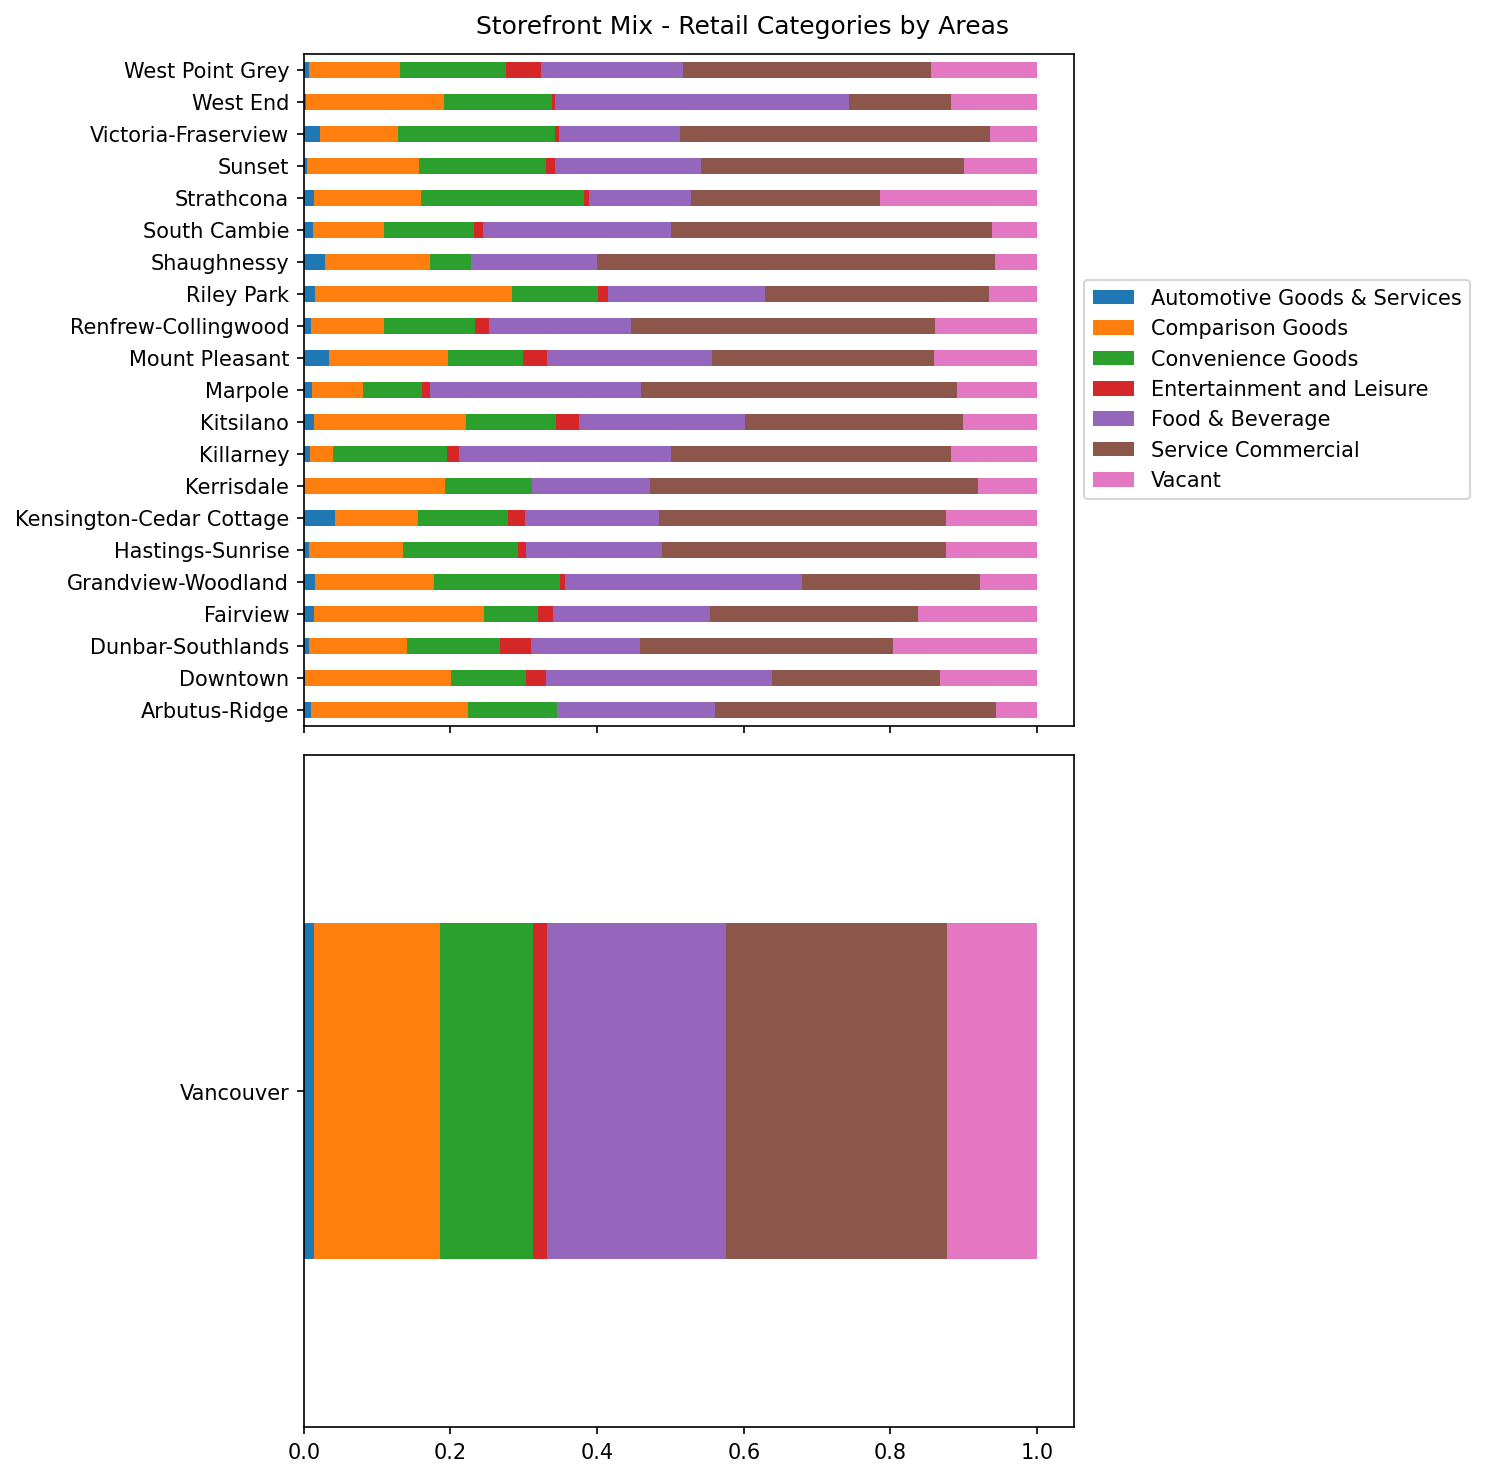

In [91]:
# Table 1
query_table2_pivot = pd.pivot_table(query_table2, values='area_categ_prop', index='Area', columns='Retail category')
query_table2_pivot.fillna(0, inplace=True)
# Table 2
query_table0_modified = query_table0.loc[:, ['Retail category', 'ideal_prop']]
query_table0_modified['Area'] = 'Vancouver'
query_table0_pivot = pd.pivot_table(query_table0_modified, values='ideal_prop', index='Area', columns='Retail category')
# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# ax1
plt.suptitle('Storefront Mix - Retail Categories by Areas', color='black')
query_table2_pivot.plot(ax=ax1, kind='barh', stacked=True)
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# ax2
query_table0_pivot.plot(ax=ax2, kind='barh', stacked=True, legend=False)
ax1.set_ylabel('')
ax2.set_ylabel('')
fig.tight_layout()
plt.show()

### Step 3: areas with the greatest disparity

Now, when I have a table (view) of disparities in all area/categories, I'd like to find the **most significant** disparities.

**Methodology**:
1. Assign `percentile_rank` to `disparity` over `Retail category`.
    - Why use PARTITION BY `Retail category` and not over the whole column? Because `Retail category` proportions are not equal. For example, `Automotive Goods & Services` occupies only 1.4% of all stores (an ideal proportion of the City). But some `Area` such as Kensington-Cedar Cottage can have 4.3% of this type of store. The absolute difference in approximately 3% doesn't seem a huge number, but _relative_ difference within this category might be considered significant.



In [9]:
query3 = '''
SELECT *,
       CASE
           WHEN a.disparity < 0 THEN 'DEFICIT'
           ELSE 'SURPLUS'
           END AS state
FROM (SELECT Area,
             `Retail category`,
             disparity,
             PERCENT_RANK() OVER (PARTITION BY `Retail category` ORDER BY disparity) AS percentile_rank
      FROM stores_disparity) AS a
WHERE a.percentile_rank IN (1, 0)
ORDER BY percentile_rank DESC;
'''

query_table3 = pd.read_sql_query(query3, engine)
generate_ascii_table(query_table3)

Area,Retail category,disparity,percentile_rank,state
West End,Food & Beverage,0.1576,1.0,SURPLUS
Riley Park,Comparison Goods,0.0978,1.0,SURPLUS
Strathcona,Convenience Goods,0.0969,1.0,SURPLUS
Strathcona,Vacant,0.0921,1.0,SURPLUS
Kensington-Cedar Cottage,Automotive Goods & Services,0.0288,1.0,SURPLUS
Shaughnessy,Service Commercial,0.2416,1.0,SURPLUS
West Point Grey,Entertainment and Leisure,0.0281,1.0,SURPLUS
West End,Service Commercial,-0.1625,0.0,DEFICIT
Strathcona,Food & Beverage,-0.105,0.0,DEFICIT
Arbutus-Ridge,Vacant,-0.0663,0.0,DEFICIT


### Summary table for Step 3

**Category perspective**

In [80]:
pd.pivot_table(query_table3, values='Area', index='Retail category', columns='state', aggfunc=np.sum)

state,DEFICIT,SURPLUS
Retail category,,
Automotive Goods & Services,Downtown,Kensington-Cedar Cottage
Comparison Goods,Killarney,Riley Park
Convenience Goods,Shaughnessy,Strathcona
Entertainment and Leisure,West End,West Point Grey
Food & Beverage,Strathcona,West End
Service Commercial,West End,Shaughnessy
Vacant,Arbutus-Ridge,Strathcona


**Area perspective**

In [81]:
query_table3_subset = query_table3.loc[:, ['state', 'Area', 'Retail category']]
query_table3_subset = query_table3_subset.groupby(['Area', 'state'])['Retail category'].agg(','.join)
pd.pivot_table(query_table3_subset.reset_index(), values='Retail category', index='Area', columns='state',
               aggfunc=np.sum)

state,DEFICIT,SURPLUS
Area,,
Arbutus-Ridge,Vacant,NaN
Downtown,Automotive Goods & Services,NaN
Kensington-Cedar Cottage,NaN,Automotive Goods & Services
Killarney,Comparison Goods,NaN
Riley Park,NaN,Comparison Goods
Shaughnessy,Convenience Goods,Service Commercial
Strathcona,Food & Beverage,"Convenience Goods,Vacant"
West End,"Service Commercial,Entertainment and Leisure",Food & Beverage
West Point Grey,NaN,Entertainment and Leisure


### Visualization of Step 3

In [87]:
query_category = '''
SELECT *,
       CASE
           WHEN a.disparity < 0 THEN 'DEFICIT'
           ELSE 'SURPLUS'
           END AS state
FROM (SELECT Area,
             `Retail category`,
             disparity,
             PERCENT_RANK() OVER (PARTITION BY `Retail category` ORDER BY disparity) AS percentile_rank
      FROM stores_disparity) AS a
WHERE a.`Retail category` = %(retail_category)s
ORDER BY percentile_rank DESC;
'''

query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': 'Food & Beverage'})

In [121]:
geoviz(district_file_path, query_category_table, 'Food & Beverage')

In [122]:
rc = 'Comparison Goods'
query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': rc})
geoviz(district_file_path, query_category_table, rc)

In [123]:
rc = 'Convenience Goods'
query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': rc})
geoviz(district_file_path, query_category_table, rc)

In [124]:
rc = 'Service Commercial'
query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': rc})
geoviz(district_file_path, query_category_table, rc)

In [125]:
rc = 'Automotive Goods & Services'
query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': rc})
geoviz(district_file_path, query_category_table, rc)

In [127]:
rc = 'Entertainment and Leisure'
query_category_table = pd.read_sql_query(query_category, engine, params={'retail_category': rc})
geoviz(district_file_path, query_category_table, rc)

In [91]:
query_disparity = '''
SELECT * FROM stores_disparity
'''
df_disparity = pd.read_sql_query(query_disparity, engine)
df_disparity.head()

,Area,Retail category,area_category_count,area_count,ideal_categ_prop,area_categ_prop,disparity
0,Downtown,Food & Beverage,460,1493,0.2441,0.3081,0.0640
1,Downtown,Service Commercial,342,1493,0.3013,0.2291,-0.0722
2,Downtown,Comparison Goods,297,1493,0.1716,0.1989,0.0273
3,Kensington-Cedar Cottage,Service Commercial,273,699,0.3013,0.3906,0.0893
4,Kitsilano,Service Commercial,254,853,0.3013,0.2978,-0.0035


In [118]:
district = gpd.read_file(district_file_path)
# Let's index by district name
cendf = district
cendf.set_index('name', inplace=True)
cendf_2 = cendf
#left join the to the cendf file
cendf_2['name_2'] = cendf_2.index

# plot the map
# fig = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
#                            locations=cendf_4.index,
#                            color="disparity",
#                            color_continuous_scale = 'YlGnBu',
#                            center={"lat": 49.246292, "lon": -123.116226}, # Vancouver
#                            mapbox_style="carto-positron",
#                            opacity=0.75,
#                            zoom=11,
#                            title = '')


retail_categories = list(df_disparity['Retail category'].unique())

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=['Food & Beverage', 'Services'],
                    specs=[[{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}]])

result = df_disparity[df_disparity['Retail category'] == 'Food & Beverage']
cendf_3 = pd.merge(cendf_2, result, left_on='name_2', right_on='Area', how='left')
cendf_4 = cendf_3.to_crs(epsg=4326)
#

fig1 = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
                            locations=cendf_4.index,
                            color="disparity",
                            color_continuous_scale='YlGnBu',
                            center={"lat": 49.246292, "lon": -123.116226},  # Vancouver
                            mapbox_style="carto-positron",
                            opacity=0.75,
                            zoom=11,
                            title='')

fig.add_trace(fig1['data'][0], row=1, col=1)

cendf_3 = pd.merge(cendf_2, df_disparity[df_disparity['Retail category'] == 'Comparison Goods'], left_on='name_2',
                   right_on='Area', how='left')
cendf_4 = cendf_3.to_crs(epsg=4326)
fig2 = px.choropleth_mapbox(cendf_4, geojson=cendf_4,
                            locations=cendf_4.index,
                            color="disparity",
                            color_continuous_scale='YlGnBu',
                            center={"lat": 49.246292, "lon": -123.116226},  # Vancouver
                            mapbox_style="carto-positron",
                            opacity=0.75,
                            zoom=11,
                            title='')

fig.add_trace(fig2['data'][0], row=1, col=1)

fig.update_layout(coloraxis_showscale=True)  # update
fig.update_mapboxes(style='white-bg',
                    center={"lat": 49.246292, "lon": -123.116226},
                    zoom=10)

fig.show()

In [96]:
retail_categories

['Food & Beverage',
 'Service Commercial',
 'Comparison Goods',
 'Vacant',
 'Convenience Goods',
 'Entertainment and Leisure',
 'Automotive Goods & Services']

**Insights on Part 1**:

1. The final table shows us the most considerable disparities across areas of Vancouver;
2. A positive `area_categ_prop_diff` tells us that there is a surplus of stores of a specific retail category (compared to the ideal City’s proportion). And the negative number hints about the shortage of certain stores;
3. For example:
    - A significant surplus of `Service Commercial` stores in the Shaugnessy area while there is a lack of this type of stores in the West End;
    - A significant surplus of `Vacant` spaces in Strathcona can indicate poor economic conditions in that area;
        - Maybe it makes sense to introduce more `Food & Beverage` stores to that region as there is a significant deficit;
    - Kensington-Cedar Cottage is the place where you can easily find a shop to repair your vehicle compared to other areas (`Automotive Goods & Services`).

## Part 2: Analysing changes over time 2021/2020

So far, I was exploring the state of store inventories in 2021 year.

### Step 1: How has retail categories proportion changed over one year?

In [36]:
query4 = '''
SELECT a.`Retail category`,
b.prop_2020 * 100 AS "Proportion,% in 2020",
a.prop_2021 * 100 AS "Proportion,% in 2021",
(a.prop_2021 - b.prop_2020) * 100 AS "Proportion difference 2021/20, %"
FROM (SELECT `Retail category`,
             COUNT(*)                         AS stores,
             COUNT(*) / SUM(COUNT(*)) OVER () AS prop_2021
      FROM stores
      WHERE Year = 2021
      GROUP BY 1) AS a
         LEFT OUTER JOIN
     (SELECT `Retail category`,
             COUNT(*)                         AS stores,
             COUNT(*) / SUM(COUNT(*)) OVER () AS prop_2020
      FROM stores
      WHERE Year = 2020
      GROUP BY 1) AS b ON a.`Retail category` = b.`Retail category`
ORDER BY "Proportion difference,%" DESC;
'''

query_table4 = pd.read_sql_query(query4, engine)
query_table4.loc[:, ['Retail category' ,'Proportion difference 2021/20, %']]

,Retail category,"Proportion difference 2021/20, %"
0,Automotive Goods & Services,-0.07
1,Comparison Goods,-0.87
2,Convenience Goods,-0.05
3,Entertainment and Leisure,-0.09
4,Food & Beverage,-1.14
5,Service Commercial,-0.55
6,Vacant,2.78


In [ ]:
query_table4_modified = query_table4.set_index('Retail category')
# query_table4_modified.rename(columns = {'Proportion,% in 2020':'2020', 'Proportion,% in 2021':'2021'},
#                              inplace = True)
query_table4_modified = query_table4_modified.loc[:, ['Proportion,% in 2020', 'Proportion,% in 2021']].T

# Plot
query_table4_modified.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**Insights:**

1. The `Vacant` spaces increased by almost 3% in 2021 compared to 2020 (Covid?);
2. Others retail categories hasn't changed much. This tells us that the city of Vancouver is well-balanced.

### Step 2: Which areas have been the main contributors to vacancy rate change

In [40]:
query5 = '''
SELECT a.`Area`,
       b.prop_2020 * 100                 AS prop_2020_pct,
       a.prop_2021 * 100                 AS prop_2021_pct,
       (a.prop_2021 - b.prop_2020) * 100 AS prop_diff_pct,
       a.stores_2021 - b.stores_2020     AS abs_diff
FROM (SELECT `Area`,
             COUNT(*)                         AS stores_2021,
             COUNT(*) / SUM(COUNT(*)) OVER () AS prop_2021
      FROM stores
      WHERE Year = 2021
        AND `Retail category` = 'Vacant'
      GROUP BY 1) AS a
         LEFT OUTER JOIN
     (SELECT `Area`,
             COUNT(*)                         AS stores_2020,
             COUNT(*) / SUM(COUNT(*)) OVER () AS prop_2020
      FROM stores
      WHERE Year = 2020
        AND `Retail category` = 'Vacant'
      GROUP BY 1) AS b ON a.`Area` = b.`Area`
ORDER BY prop_diff_pct DESC;
'''

query_table5 = pd.read_sql_query(query5, engine)
generate_ascii_table(query_table5)

Area,prop_2020_pct,prop_2021_pct,prop_diff_pct,abs_diff
Downtown,17.12,19.92,2.8,65
Fairview,7.91,9.81,1.9,36
Grandview-Woodland,1.95,3.03,1.08,15
West End,6.23,7.18,0.95,23
Kensington-Cedar Cottage,8.3,8.8,0.5,23
Dunbar-Southlands,2.46,2.83,0.37,9
Renfrew-Collingwood,4.02,4.35,0.33,12
Arbutus-Ridge,0.39,0.61,0.22,3
South Cambie,0.39,0.51,0.12,2
Sunset,2.59,2.63,0.04,6


**Insights:**

1. Downtown area was the main contributor to rise in vacancy rate, 65 more empty spaces in 2021 compared to 2020, that is 2.8% increase. Which makes sense (that Downtown is the main contributor) as it is the major job cluster, the busiest area and so on.

NOTE: in column `abs_diff` vs column `prop_diff_pct` the sign of change can unmatch because the proportion is calculated by dividing by total number of stores that particular year (and they differ) while abs change doesn't count that.

### Part C: Vacancy rate across areas of Vancouver

In this final part I'm curious how vacancy rate (number of vacant stores of all stores in an area) is distributed across areas.

**Methodology:**
1. Calculate `vacancy_rate` as `vacant_stores` (number of vacant stores in area) divided by `stores` (number of stores in that area);
2. Put table from step 1 described above into VIEW to save space, as I'm going to use this in next steps;
3. Calculate `percentile` of `vacancy_rate` column. I haven't found function for that, so:
    - Set MAX and MIN `vacancy_rate`;
    - Calculate percentile with following formula: (vacancy_rate - MIN) / (RANGE), where RANGE = MAX - MIN;
4. Use `percentile` to assign labels (HIGH, RELATIVE HIGH/LOW, LOW) saved in column `mark`.

In [ ]:
query6 = '''
CREATE VIEW vacancy_table AS
SELECT a.Area, a.stores, b.vacant_stores, b.vacant_stores / a.stores AS vacancy_rate
FROM ((SELECT `Area`, COUNT(*) AS stores
       FROM stores
       WHERE Year = 2021
       GROUP BY 1) AS a
    LEFT OUTER JOIN
    (SELECT `Area`, COUNT(*) AS vacant_stores
     FROM stores
     WHERE Year = 2021
       AND `Retail category` = 'Vacant'
     GROUP BY 1) AS b ON a.`Area` = b.`Area`);
'''

query7 = "SET @max_vacancy_rate := (SELECT MAX(vacancy_rate) FROM vacancy_table);"
query8 = "SET @min_vacancy_rate := (SELECT MIN(vacancy_rate) FROM vacancy_table);"

query9 = '''
SELECT temp.*,
       CASE
           WHEN temp.percentile < 0.25 THEN 'LOW'
           WHEN temp.percentile BETWEEN 0.25 AND 0.5 THEN 'RELATIVELY LOW'
           WHEN temp.percentile BETWEEN 0.5 AND 0.75 THEN 'RELATIVELY HIGH'
           WHEN temp.percentile > 0.75 THEN 'HIGH'
           ELSE 'MEDIUM'
           END AS mark
FROM (SELECT *,
             ROUND((vacancy_table.vacancy_rate - @min_vacancy_rate) / (@max_vacancy_rate - @min_vacancy_rate),
                   2) AS percentile
      FROM vacancy_table) AS temp
ORDER BY temp.percentile;
'''

# engine.execute(query6) # execute query create view, no need to run twice
engine.execute(query7)  # execute query set max
engine.execute(query8)  # execute query set min

query_table9 = pd.read_sql_query(query9, engine)
generate_ascii_table(query_table9)

**Insights:**

1. Vacancy rates range considerably across areas.
    - It's low (meaning healthy) for such areas as Arbutus-Ridge, Shaughnessy etc.;
    - It's high (not healthy) for such areas as Strathcona, Dunbar-Southlands

## References

Open Data Vancouver. Storefronts Inventory. Retrieved November 20, 2022 from https://opendata.vancouver.ca/explore/dataset/storefronts-inventory/